In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tensorflow.keras import layers
from keras.callbacks import TensorBoard

In [ ]:
# Definir as pastas e classes
pasta_imagens = "/content/drive/MyDrive/Ciência da computação/7° Semestre/Visão Computacional/TrabalhoFinal/img_CNN"
pastas = ['cereja', 'cafe', 'banana']
num_classes = len(pastas)

# Lista para armazenar as imagens e rótulos
imagens = []
rotulos = []

# Definir o tamanho desejado das imagens
tamanho_desejado = (224, 224)

# Carregar as imagens e seus respectivos rótulos
for classe, pasta in enumerate(pastas):
    caminho_pasta = pasta_imagens + '/' + pasta
    arquivos_imagem = os.listdir(caminho_pasta)

    for arquivo_imagem in arquivos_imagem:
        caminho_imagem = caminho_pasta + '/' + arquivo_imagem
        imagem = cv2.imread(caminho_imagem)

        if imagem is None:
            print("Erro ao ler a imagem {}. Continuando para a próxima imagem.".format(caminho_imagem))
            continue

        # Converter a imagem para o tipo de dados esperado pela função cv2.resize
        imagem = np.array(imagem, dtype=np.uint8)

        # Redimensionar a imagem para o tamanho desejado
        imagem_redimensionada = cv2.resize(imagem, tamanho_desejado)

        # Adicionar a imagem redimensionada e o rótulo às listas
        imagens.append(imagem_redimensionada)
        rotulos.append(classe)

# Converter as listas em arrays numpy
imagens = np.array(imagens, dtype=object)
rotulos = np.array(rotulos)

In [ ]:
# Dividir o conjunto de dados em treinamento e teste
train_data, test_data, train_labels, test_labels = train_test_split(imagens, rotulos, test_size=0.2, random_state=42)

from skimage.transform import resize

# Converter as imagens para o tipo float
train_data = train_data.astype(np.float32)
test_data = test_data.astype(np.float32)

# Redimensionar os dados de entrada
train_data = np.array([resize(img, tamanho_desejado) for img in train_data])
test_data = np.array([resize(img, tamanho_desejado) for img in test_data])

# Converter os rótulos para o formato one-hot
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)

In [ ]:
# Criar a arquitetura ResNet
def residual_block(x, filters, downsample=False):
    identity = x

    x = layers.Conv2D(filters, kernel_size=(3, 3), strides=(1 if not downsample else 2, 1 if not downsample else 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)

    if downsample:
        identity = layers.Conv2D(filters, kernel_size=(1, 1), strides=(2, 2), padding='same')(identity)
        identity = layers.BatchNormalization()(identity)

    x = layers.Add()([x, identity])
    x = layers.ReLU()(x)
    return x

In [ ]:
def ResNet(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=128, downsample=True)
    x = residual_block(x, filters=128)
    x = residual_block(x, filters=256, downsample=True)
    x = residual_block(x, filters=256)
    x = layers.GlobalAveragePooling2D()(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
# Definir o formato de entrada
input_shape = tamanho_desejado + (3,)  # (224, 224, 3)

# Criar uma instância do modelo ResNet
model = ResNet(input_shape, num_classes)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Treinar o modelo com o callback do TensorBoard
history = model.fit(train_data, train_labels, epochs=20, validation_data=(test_data, test_labels))

Epoch 1/20
32/32 [==============================] - 27s 186ms/step - loss: 1.1806 - accuracy: 0.5585 - val_loss: 1221.3346 - val_accuracy: 0.2902
Epoch 2/20
32/32 [==============================] - 3s 99ms/step - loss: 0.7635 - accuracy: 0.6952 - val_loss: 85.7990 - val_accuracy: 0.3725
Epoch 3/20
32/32 [==============================] - 3s 99ms/step - loss: 0.7187 - accuracy: 0.7040 - val_loss: 24.7501 - val_accuracy: 0.3333
Epoch 4/20
32/32 [==============================] - 3s 98ms/step - loss: 0.6664 - accuracy: 0.7296 - val_loss: 1.3952 - val_accuracy: 0.6157
Epoch 5/20
32/32 [==============================] - 3s 104ms/step - loss: 0.6286 - accuracy: 0.7542 - val_loss: 1.6416 - val_accuracy: 0.4627
Epoch 6/20
32/32 [==============================] - 3s 102ms/step - loss: 0.6426 - accuracy: 0.7325 - val_loss: 1.0010 - val_accuracy: 0.6431
Epoch 7/20
32/32 [==============================] - 3s 99ms/step - loss: 0.5678 - accuracy: 0.7650 - val_loss: 1.4697 - val_accuracy: 0.5451
Epoc

In [ ]:
# Treinar o modelo com otimizador SGD
model_sgd = ResNet(input_shape, num_classes)
model_sgd.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history_sgd = model_sgd.fit(train_data, train_labels, epochs=20, validation_data=(test_data, test_labels))

Epoch 1/20
32/32 [==============================] - 9s 131ms/step - loss: 0.8854 - accuracy: 0.5988 - val_loss: 4.8628 - val_accuracy: 0.3373
Epoch 2/20
32/32 [==============================] - 3s 106ms/step - loss: 0.7466 - accuracy: 0.6745 - val_loss: 2.7382 - val_accuracy: 0.3373
Epoch 3/20
32/32 [==============================] - 3s 101ms/step - loss: 0.6635 - accuracy: 0.7414 - val_loss: 3.0149 - val_accuracy: 0.4000
Epoch 4/20
32/32 [==============================] - 3s 100ms/step - loss: 0.6081 - accuracy: 0.7561 - val_loss: 1.8288 - val_accuracy: 0.4863
Epoch 5/20
32/32 [==============================] - 3s 102ms/step - loss: 0.5486 - accuracy: 0.7768 - val_loss: 3.3013 - val_accuracy: 0.4471
Epoch 6/20
32/32 [==============================] - 3s 106ms/step - loss: 0.5654 - accuracy: 0.7768 - val_loss: 0.6915 - val_accuracy: 0.6784
Epoch 7/20
32/32 [==============================] - 3s 101ms/step - loss: 0.5018 - accuracy: 0.8024 - val_loss: 0.7617 - val_accuracy: 0.7020
Epoch 

In [ ]:
# Treinar o modelo com taxa de aprendizado ajustada
model_lr = ResNet(input_shape, num_classes)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_lr.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history_lr = model_lr.fit(train_data, train_labels, epochs=20, validation_data=(test_data, test_labels))

Epoch 1/20
32/32 [==============================] - 8s 127ms/step - loss: 1.0096 - accuracy: 0.4936 - val_loss: 1.4073 - val_accuracy: 0.3765
Epoch 2/20
32/32 [==============================] - 3s 101ms/step - loss: 0.8542 - accuracy: 0.6382 - val_loss: 1.1515 - val_accuracy: 0.3804
Epoch 3/20
32/32 [==============================] - 3s 102ms/step - loss: 0.8077 - accuracy: 0.6676 - val_loss: 1.0170 - val_accuracy: 0.4627
Epoch 4/20
32/32 [==============================] - 3s 104ms/step - loss: 0.7674 - accuracy: 0.6962 - val_loss: 0.9331 - val_accuracy: 0.5216
Epoch 5/20
32/32 [==============================] - 3s 107ms/step - loss: 0.7509 - accuracy: 0.7021 - val_loss: 0.8771 - val_accuracy: 0.6196
Epoch 6/20
32/32 [==============================] - 3s 101ms/step - loss: 0.7282 - accuracy: 0.6962 - val_loss: 0.8770 - val_accuracy: 0.6314
Epoch 7/20
32/32 [==============================] - 3s 101ms/step - loss: 0.7072 - accuracy: 0.7178 - val_loss: 0.8247 - val_accuracy: 0.6392
Epoch 

In [ ]:
# Imprimir a acurácia durante o treinamento
accuracy = [f"{acc*100:.2f}%" for acc in history.history['accuracy']]
print("Acurácia durante o treinamento:")
print(accuracy)
print()

# Imprimir a perda durante o treinamento com duas casas decimais
loss = [f"{l:.2f}" for l in history.history['loss']]
print("Perda durante o treinamento:")
print(loss)
print()

Acurácia durante o treinamento:
['55.85%', '69.52%', '70.40%', '72.96%', '75.42%', '73.25%', '76.50%', '79.65%', '79.45%', '77.78%', '80.14%', '81.12%', '81.42%', '84.07%', '82.69%', '79.25%', '84.46%', '84.17%', '82.40%', '86.14%']

Perda durante o treinamento:
['1.18', '0.76', '0.72', '0.67', '0.63', '0.64', '0.57', '0.55', '0.51', '0.55', '0.51', '0.51', '0.48', '0.44', '0.44', '0.50', '0.43', '0.43', '0.45', '0.36']



In [ ]:
# Imprimir a acurácia durante o treinamento com otimizador SGD
accuracy_sgd = [f"{acc*100:.2f}%" for acc in history_sgd.history['accuracy']]
print("Acurácia durante o treinamento (SGD):")
print(accuracy_sgd)
print()

# Imprimir a perda durante o treinamento com otimizador SGD
loss_sgd = [f"{l:.2f}" for l in history_sgd.history['loss']]
print("Perda durante o treinamento (SGD):")
print(loss_sgd)
print()

Acurácia durante o treinamento (SGD):
['59.88%', '67.45%', '74.14%', '75.61%', '77.68%', '77.68%', '80.24%', '81.81%', '80.24%', '83.48%', '84.27%', '85.64%', '89.18%', '88.00%', '88.99%', '87.12%', '91.25%', '91.35%', '93.31%', '95.18%']

Perda durante o treinamento (SGD):
['0.89', '0.75', '0.66', '0.61', '0.55', '0.57', '0.50', '0.48', '0.49', '0.44', '0.41', '0.36', '0.31', '0.30', '0.29', '0.32', '0.24', '0.24', '0.21', '0.17']



In [ ]:
# Imprimir a acurácia durante o treinamento com taxa de aprendizado ajustada
accuracy_lr = [f"{acc*100:.2f}%" for acc in history_lr.history['accuracy']]
print("Acurácia durante o treinamento (Learning Rate Ajustada):")
print(accuracy_lr)
print()

# Imprimir a perda durante o treinamento com taxa de aprendizado ajustada
loss_lr = [f"{l:.2f}" for l in history_lr.history['loss']]
print("Perda durante o treinamento (Learning Rate Ajustada):")
print(loss_lr)
print()

Acurácia durante o treinamento (Learning Rate Ajustada):
['49.36%', '63.82%', '66.76%', '69.62%', '70.21%', '69.62%', '71.78%', '72.96%', '73.35%', '74.53%', '74.93%', '75.61%', '76.89%', '78.47%', '78.27%', '80.33%', '78.86%', '79.94%', '80.63%', '81.02%']

Perda durante o treinamento (Learning Rate Ajustada):
['1.01', '0.85', '0.81', '0.77', '0.75', '0.73', '0.71', '0.69', '0.68', '0.66', '0.64', '0.64', '0.61', '0.59', '0.58', '0.55', '0.56', '0.54', '0.52', '0.51']



In [ ]:
# Salvar o modelo com o nome model_lr.h5
model_sgd.save('/content/drive/MyDrive/Ciência da computação/7° Semestre/Visão Computacional/TrabalhoFinal/img_inferencia/model_sgd_resnet.h5')

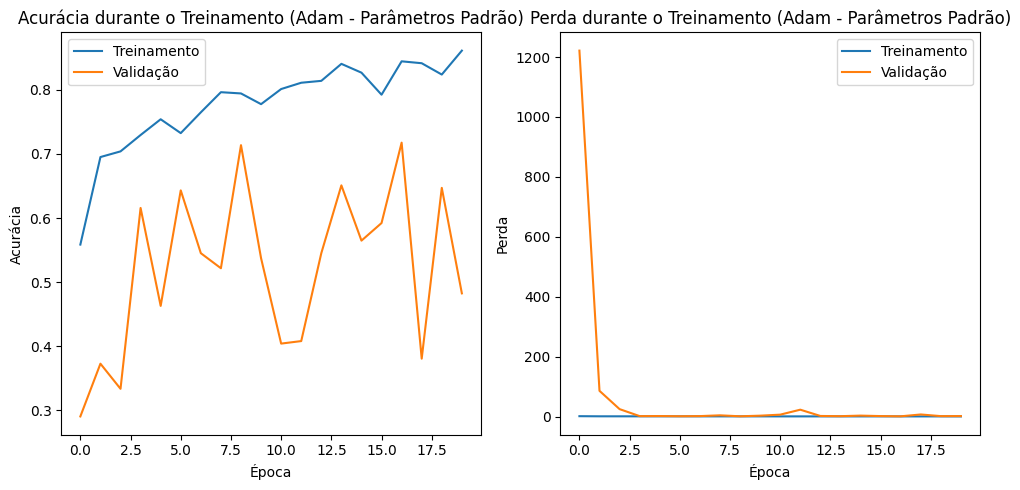

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia durante o Treinamento (Adam - Parâmetros Padrão)')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend(['Treinamento', 'Validação'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perda durante o Treinamento (Adam - Parâmetros Padrão)')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend(['Treinamento', 'Validação'], loc='upper right')

plt.tight_layout()
plt.show()

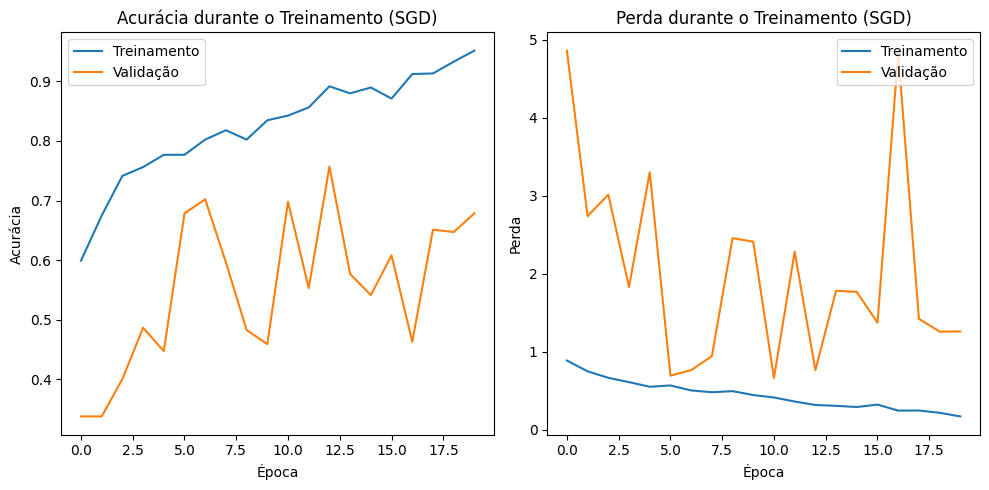

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_sgd.history['accuracy'])
plt.plot(history_sgd.history['val_accuracy'])
plt.title('Acurácia durante o Treinamento (SGD)')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend(['Treinamento', 'Validação'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_sgd.history['loss'])
plt.plot(history_sgd.history['val_loss'])
plt.title('Perda durante o Treinamento (SGD)')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend(['Treinamento', 'Validação'], loc='upper right')

plt.tight_layout()
plt.show()

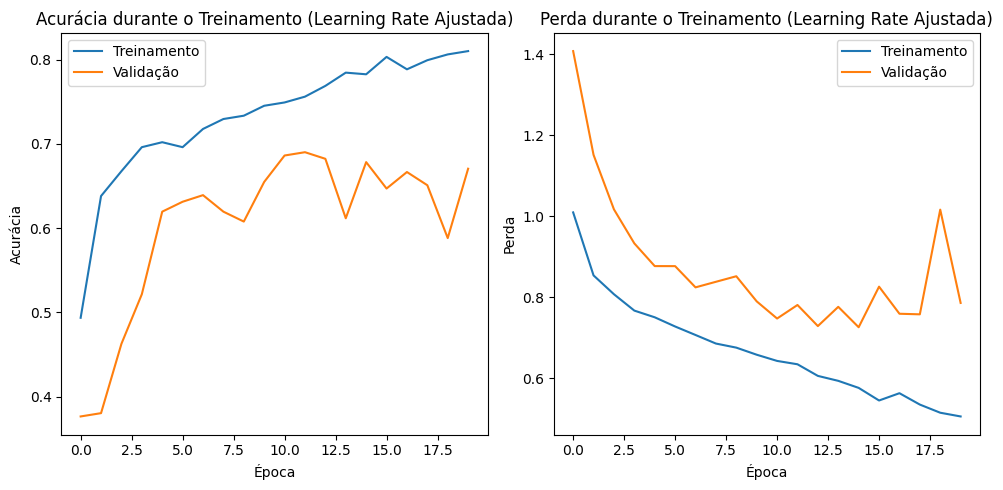

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_lr.history['accuracy'])
plt.plot(history_lr.history['val_accuracy'])
plt.title('Acurácia durante o Treinamento (Learning Rate Ajustada)')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend(['Treinamento', 'Validação'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_lr.history['loss'])
plt.plot(history_lr.history['val_loss'])
plt.title('Perda durante o Treinamento (Learning Rate Ajustada)')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend(['Treinamento', 'Validação'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2

# Carregar o modelo treinado
modelo = load_model('/content/drive/MyDrive/Ciência da computação/7° Semestre/Visão Computacional/TrabalhoFinal/img_inferencia/model_sgd_resnet.h5')

# Carregar a imagem a ser reconhecida
caminho_imagem = '/content/drive/MyDrive/Ciência da computação/7° Semestre/Visão Computacional/TrabalhoFinal/img_inferencia/imgg.png'
imagem = cv2.imread(caminho_imagem)

# Redimensionar a imagem para o tamanho desejado
tamanho_desejado = (224, 224)
imagem_redimensionada = cv2.resize(imagem, tamanho_desejado)

# Realizar a previsão
previsao = modelo.predict(imagem_redimensionada.reshape(1, 224, 224, 3))

# Mapear as classes para seus respectivos rótulos
classes = ['cereja', 'cafe', 'banana']
resultado = previsao.argmax(axis=-1)
classe_prevista = classes[resultado[0]]

# Exibir o resultado da previsão
print("A imagem é classificada como:", classe_prevista)

1/1 [==============================] - 0s 269ms/step
A imagem é classificada como: cereja
